In [1]:
import torch
import random
import matplotlib.pyplot as plt
from dataset_util.dataset import BinsceneA
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset
import torch.nn as nn
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


BATCH_SIZE_TRAIN = 6
BATCH_SIZE_EVAL = 32
# create an instance of the BinsceneA dataset
binscene_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='full', premultiply_alpha=True)


# display some information on the dataset
print(f'The dataset contains {len(binscene_dataset)} samples.')
print(f'It contains objects from the following {len(binscene_dataset.class_labels)} classes:')
print(binscene_dataset.class_labels, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(binscene_dataset))
# 
img_tensor, object_visibility_vector = binscene_dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(binscene_dataset, batch_size=BATCH_SIZE_TRAIN,
                                          shuffle=True, num_workers=2)
print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of an object visibility vector is:', object_visibility_vector.shape)

The dataset contains 200000 samples.
It contains objects from the following 17 classes:
['cracker_box' 'sugar_box' 'mustard_bottle' 'potted_meat_can' 'banana'
 'bleach_cleanser' 'mug' 'sponge' 'spatula' 'power_drill' 'wood_block'
 'extra_large_clamp' 'softball' 'golf_ball' 'dice' 'toy_airplane'
 'red_box'] 

The shape of an image tensor is: torch.Size([3, 360, 640])
The shape of an object visibility vector is: torch.Size([17])


The shape of the image tensor is: torch.Size([3, 256, 384]) tensor(0.) tensor(0.9961)
The shape of the object visibility vector is: torch.Size([17])


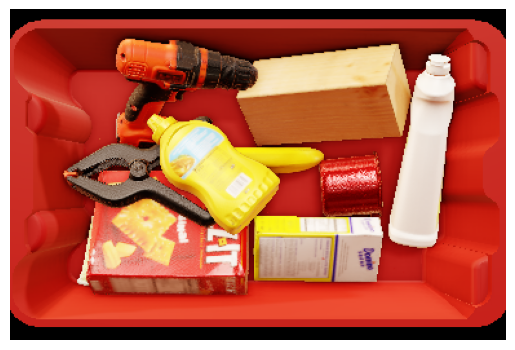

Visible objects are banana, bleach_cleanser, cracker_box, extra_large_clamp, mug, mustard_bottle, power_drill, red_box, sponge, sugar_box and wood_block.


In [3]:
import torchvision
# we don't need this module to warn us about all kinds of stuff
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import Resize, CenterCrop, Compose, Normalize

# transform is applied to the images, target transform is applied to the visibility vectors
# transformS is applied to a tuple of (image, visibility vector)
# These functions can be defined and chained as desired, but they expect torch tensors as inputs

# in this case we only transform the images by resizing them
# define the transform, this is just a function which takes and returns a tensor
resize_transform = Resize(size=(90, 160), antialias=True)
crop_transform = CenterCrop((256,384)) #Lambda(lambda t: t[...,14:90-14,32:160-32])
norm_transform = Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
image_transform2 = Compose([norm_transform,crop_transform])
image_transform = Compose([resize_transform, crop_transform])
# initialize a dataset which applies the transform to each sample image
transformed_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='train', premultiply_alpha=True, 
                                transform=crop_transform)
trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=BATCH_SIZE_TRAIN,
                                          shuffle=True, num_workers=12,pin_memory=True)

transformed_dataset_eval = BinsceneA(root='/data/BinsceneA_16_objects', split='val', premultiply_alpha=True, 
                                transform=crop_transform)
evalloader = torch.utils.data.DataLoader(transformed_dataset_eval, batch_size=BATCH_SIZE_EVAL,
                                          shuffle=True, num_workers=12,pin_memory=True)
# get a sample and print the shapes
sample_idx = random.randrange(len(transformed_dataset))
img_tensor_new, object_visibility_vector = transformed_dataset.__getitem__(sample_idx)
print('The shape of the image tensor is:', img_tensor_new.shape, img_tensor.min(), img_tensor.max())
print('The shape of the object visibility vector is:', object_visibility_vector.shape)
# visualize it
fig, ax = plt.subplots()
ax, image_description = transformed_dataset.show(img_tensor_new, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

In [4]:
from ldm_autoencoder import load_autoencoder

ldm_autoencoder_path = '/data/ldm_autoencoder_data/'

kl_f4_dict = {'checkpoint': 'autoencoder_kl_64x64x3.pth', 'config': 'autoencoder_kl_64x64x3.yaml'} # PSNR 27.53
kl_f8_dict = {'checkpoint': 'autoencoder_kl_32x32x4.pth', 'config': 'autoencoder_kl_32x32x4.yaml'} # PSNR 24.19
kl_f16_dict = {'checkpoint': 'autoencoder_kl_16x16x16.pth', 'config': 'autoencoder_kl_16x16x16.yaml'} # PSNR 24.08
kl_f32_dict = {'checkpoint': 'autoencoder_kl_8x8x64.pth', 'config': 'autoencoder_kl_8x8x64.yaml'} # PSNR 22.27

model = load_autoencoder(kl_f16_dict, ldm_autoencoder_path).to(device)
model.eval()

Restored from /data/ldm_autoencoder_data/pytorch_checkpoints/autoencoder_kl_16x16x16.pth


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [5]:
learning_rate = 0.003
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max', factor=0.5, patience=5, verbose=True)

In [6]:
from torch.nn.functional import mse_loss as mse
def psnr_rate(input, target):
    return 10.0 * torch.log10(1 / mse(input, target, reduction='mean'))

In [7]:
@torch.no_grad()
def evaluate_autoenc(net, dataloader, device):
    BATCH_SIZE = 12
    net.eval()
    num_val_batches = len(dataloader)
    psnr_acc = []

    
    progress_bar = tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=True, position=0)
    for batch in progress_bar:
        progress_bar.set_postfix({'Total Batches': len(dataloader), 'Current PSNR': np.mean(psnr_acc)}, refresh=True)
        image, mask_true = batch[0], batch[1]

            # move images and labels to correct device and type
        image = image.to(dtype=torch.float32, memory_format=torch.channels_last).to(device)
        
        mask_pred, _ = net(image)
        psnr = psnr_rate(mask_pred, image)
        psnr_acc.append(psnr.item())
        
        
        


    net.train()
    return np.mean(psnr_acc)

In [8]:
def train_model_autoenc(
        model,
        device,
        epochs: int = 500000,
        learning_rate: float = 1e-2,
        val_percent: float = 0.1,
        img_scale: float = 0.5,
        weight_decay: float = 1e-8,
        gradient_clipping: float = 1.0,
):
    
    min_loss = 1e25
    val_loss = -1e25
    progress_bar = tqdm(range(epochs), total=epochs, position=0, leave=True)
    for epoch in progress_bar:
        mean_epoch_loss = []
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            image, mask_true = [t.to(device) for t in data]
            progress_bar.set_postfix({f'T of {[len(trainloader)]}' : i+1, 'Best loss': val_loss}, refresh=True)
            optimizer.zero_grad()
                # move images and labels to correct device and type
            image = image.to(dtype=torch.float32, memory_format=torch.channels_last)

            mask_pred, latent = model(image)#.to(device)
            loss = criterion(mask_pred, image) + 1e-6 * latent.kl().mean() #normal_kl(batch_mean,torch.log(batch_var),0,0).mean()
            mean_epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            
            
            running_loss += loss.item()
        loss_mean = np.mean(mean_epoch_loss)
        # scheduler on loss_mean with patience 10 with more aggressive learning rate
        
        val_loss_psnr = evaluate_autoenc(model, evalloader, device=device)        
        scheduler.step(val_loss_psnr)
        if val_loss_psnr > val_loss:
            val_loss = val_loss_psnr
            torch.save(model, 'autoencoder_binscene_pretrained_finetuned.pt')
        if epoch%1==0:
            print('---')
            print(f"Epoch: {epoch} | Train Loss: {loss_mean} | Best Loss: {min_loss} |")
            print(f"| Val Loss: {val_loss} |")
# validation loss for scheduler and model saving
# balance criterion and kl loss to find kl_loss weight
# track on validation set batch_mean.mean() and batch_var.mean() and val loss

In [9]:
#autoencoder = torch.load('autoencoder_binscene.pt')
#autoencoder.to(device)
#autoencoder.requires_grad_(requires_grad=False)
dataiter = iter(trainloader)
i, data = next(dataiter)

In [10]:
with torch.no_grad():
    output, test = model(i.to(device))
    print(test.mean.shape)

torch.Size([6, 16, 16, 24])


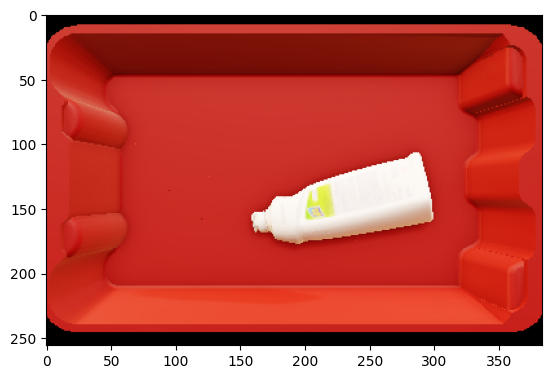

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([6, 3, 256, 384])


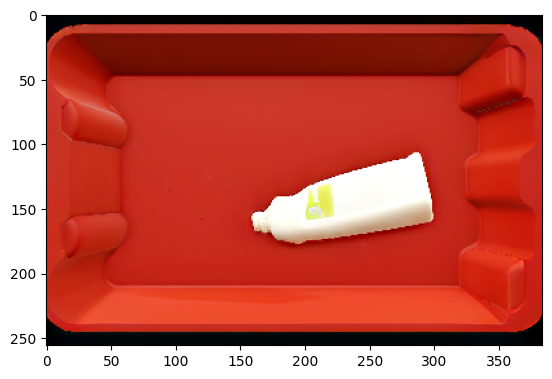

In [11]:
plt.imshow(i[0].cpu().detach().numpy().transpose((1,2,0)))
plt.show()
print(output.shape)
plt.imshow(output[0].cpu().detach().numpy().transpose((1,2,0)))
plt.show()

In [12]:
def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=2, num_channels=in_channels, eps=1e-6, affine=True)

In [13]:
def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table)#.unsqueeze(0)

In [14]:
# ResBlock für DiffusionUnet
class ResBlock(nn.Module):
    def __init__(self, in_channels, emb_dim, out_channels=None, dropout = 0.0):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
       
        self.out_channels = out_channels
        # in-layer für z (zusätzlich nonlinearity von oben in forward benutzen)
        self.Vorverarbeitung_latent = nn.Sequential(
            Normalize(in_channels),
            torch.nn.SiLU(),
            torch.nn.Conv2d(in_channels,out_channels, kernel_size=3, stride=1, padding=1)
        )
        
        # nonlinearity wird vorher auf emb angewandt, danach das hier im forward
        self.emb_proj = nn.Sequential(nn.SiLU(),
                nn.Linear(emb_dim, out_channels))
        
        #Aufrufbarer Skip(z)
        if self.in_channels != self.out_channels:
            self.skip = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=1)
        else:
            self.skip = nn.Identity()
        
        #Outlayer vor dem Skip Block
        self.Outlayer = nn.Sequential(
            Normalize(out_channels),
            torch.nn.SiLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
        )
        
        
    def forward(self, inputs):
        zs, embs = inputs
        #Verarbeitung vom Latent
        h = zs
        
        h = self.Vorverarbeitung_latent(h)
        
        # Verarbeitung vom Embedding + hinzufügen zum Latent
        h = h + self.emb_proj(embs)[:,:,None,None] #aus NxC wird NxCx1x1
        
        #Outlayer von verarbeitetem z und inkludiertem embedding
        h = self.Outlayer(h)
        
        return self.skip(zs) + h
        

In [38]:
import math
class QKVAttention(nn.Module):
    """
    A module which performs QKV attention and splits in a different order.
    """

    def __init__(self):
        super().__init__()

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x C x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % 3 == 0
        ch = width // 3
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs, ch, length),
            (k * scale).view(bs, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(bs, ch, length))
        return a.reshape(bs, -1, length)

class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(self,channels):
        super().__init__()
        self.channels = channels
        self.norm = Normalize(channels) # normalization müsst ihr dann definieren
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.attention = QKVAttention()
        self.proj_out = torch.nn.Conv1d(channels, channels, 1)

    def forward(self, x):
        #x, emb = x? gebraucht?
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)

In [53]:
class DiffusionUNet(nn.Module):
    def __init__(self, n_channels=1, channels=[128,256,512,1024,2048],t_max=1000, d_hid=32, n_classes = 17):
        super(DiffusionUNet, self).__init__()
        self.pos_enc = nn.parameter.Parameter(get_sinusoid_encoding_table(t_max, d_hid), requires_grad=False)
        
        self.first_layer = nn.Conv2d(16, channels[0], kernel_size=1, stride=1)
        
        self.time_emb_processed = nn.Sequential(
            torch.nn.Linear(d_hid, 4*d_hid, bias=False),
            torch.nn.SiLU(),
            torch.nn.Linear(4*d_hid, 4*d_hid, bias=False)
        ) 
        self.class_emb_processed = nn.Sequential(
            torch.nn.Linear(n_classes, 4*d_hid, bias=False),
            torch.nn.SiLU(),
            torch.nn.Linear(4*d_hid, 4*d_hid, bias=False)
        )
        
        
        self.downblocks_without_avgpool1 = make_resblocks(channels[0],channels[1],4*d_hid,dropout=0.01,num_resblocks=2)
        
        self.downblocks_without_avgpool2 = make_resblocks(channels[1],channels[2],4*d_hid,dropout=0.01,num_resblocks=2)

        self.downblocks_without_avgpool3 = make_resblocks(channels[2],channels[3],4*d_hid,dropout=0.01,num_resblocks=2)

        self.downblocks_without_avgpool4 = make_resblocks(channels[3],channels[4],4*d_hid,dropout=0.01,num_resblocks=2)

        
        self.downsample = nn.AvgPool2d(kernel_size =2, stride=2)
        self.final_downsample = nn.AvgPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
        
        
            
    def forward(self, inputs):
        z , t , y = inputs
        enc = self.pos_enc[t]
        t = self.time_emb_processed(enc)
        y = y.float()
        y = self.class_emb_processed(y)
        emb = t + y
        
        z = self.first_layer(z)
        #input blocks
        for resblock in self.downblocks_without_avgpool1:
            z = resblock((z,emb))
        z = self.downsample(z)
        for resblock in self.downblocks_without_avgpool2:
            z = resblock((z,emb))
        z = self.downsample(z)
        for resblock in self.downblocks_without_avgpool3:
            z = resblock((z,emb))
        z = self.downsample(z)
        for resblock in self.downblocks_without_avgpool4:
            z = resblock((z,emb))
        z = self.final_downsample(z)
        
        
        
        
        return z
        #middle blocks
        
        
        
        #output blocks
        
        
def make_resblocks(in_channels, out_channels, embed_dim, dropout, num_resblocks):
    # pro resblock
    layers = [torch.nn.Sequential(ResBlock(in_channels, embed_dim, out_channels, dropout),
             AttentionBlock(out_channels))]
    for i in range(num_resblocks-1):
        layers.append(torch.nn.Sequential(ResBlock(out_channels, embed_dim, out_channels, dropout),
             AttentionBlock(out_channels)))
    return torch.nn.ModuleList(layers)



In [54]:
diff_unet = DiffusionUNet().to(device)

B, H, W = 6, 16, 24
ts = torch.randint(0,1001, size=(B,)).to(device)
ys = torch.randint(0,2, size=(B,17)).to(device)
xs = torch.randn(size=(B,16,H,W)).to(device)
inputs = xs,ts,ys
z = diff_unet(inputs)
z.shape

torch.Size([6, 2048, 1, 2])